In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.set_rng_seed(101)

In [2]:
def scale(guess):
    weight = pyro.sample('weight', dist.Normal(guess, 1.0))
    
    return pyro.sample('measurement', dist.Normal(weight, .75))

In [3]:
conditioned_scale = pyro.condition(scale, data={'measurement': torch.tensor(9.5)})

In [4]:
def deferred_conditioned_scale(measurement, guess):
    return pyro.condition(scale, data={'measurement': measurement})(guess)

In [5]:
deferred_conditioned_scale(measurement=9.5, guess=8.5)

9.5

In [18]:
def scale_obs(guess):  # equivalent to conditioned_scale above
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
    # here we condition on measurement == 9.5
    return pyro.sample("measurement", dist.Normal(weight, 0.75), obs=torch.tensor(9.5))
scale_obs(8.5)

tensor(9.5000)

In [19]:
def perfect_guide(guess):
    loc = (0.75**2 * guess + 9.5) / (1 + 0.75**2)  # 9.14
    scale = np.sqrt(0.75**2 / (1 + 0.75**2))  # 0.6
    return pyro.sample("weight", dist.Normal(loc, scale))

In [20]:
simple_param_store = {}
a = simple_param_store.setdefault("a", torch.tensor(5))
a.item()

5

In [21]:
a = simple_param_store.setdefault("a", torch.tensor(2))
print(a.item())

5


In [31]:
def scale_parametrized_guide(guess):
    a = pyro.param('a', torch.tensor(guess))
    b = pyro.param('b', torch.tensor(1.))

    return pyro.sample('weight', dist.Normal(a, torch.abs(b)))

In [32]:
guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.Adam({"lr": 0.003}),
                     loss=pyro.infer.Trace_ELBO())


a =  9.115035057067871
b =  0.6296289563179016


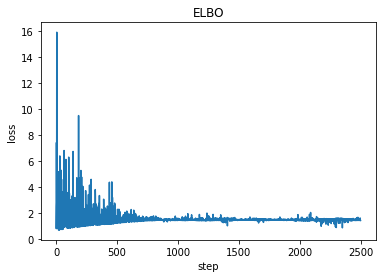

In [33]:


losses, a, b = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

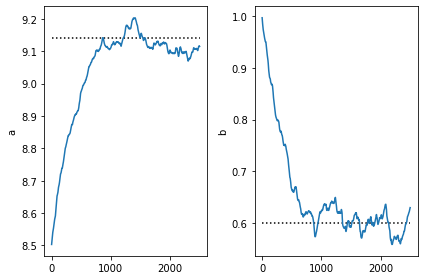

In [34]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

In [54]:
import pyro.distributions as dist
from torch.distributions import constraints
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

data = list((np.random.uniform(0, 1, 1000) < .5).astype(int))
data = [torch.tensor(float(i)) for i in data]

def model(data):
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    
    f = pyro.sample('latent_fairness', dist.Beta(alpha0, beta0))
    
    for i in range(len(data)):
        pyro.sample(f'obs_{i}', dist.Bernoulli(f), obs=data[i])

In [55]:
def guide(data):
    alpha_q = pyro.param('alpha_q', torch.tensor(15.0), constraint=constraints.positive)
    beta_q = pyro.param('beta_q', torch.tensor(15.0), constraint=constraints.positive)

    pyro.sample('latent_fairness', dist.Beta(alpha_q, beta_q))


a =  9.115035057067871
b =  0.6296289563179016


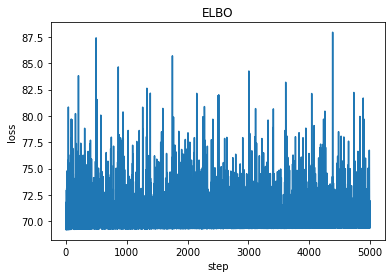

In [56]:
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 5000
losses, a, b = [], [], []
# do gradient steps
for step in range(n_steps):
    losses.append(svi.step(data))
    a.append(pyro.param('alpha_q').item())
    b.append(pyro.param('beta_q').item())


plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("alpha_q").item())
print('b = ', pyro.param("beta_q").item())

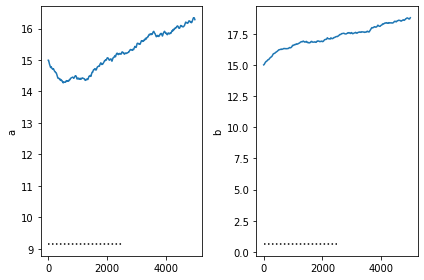

In [57]:

plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

In [59]:
import math
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))


based on the data and our prior belief, the fairness of the coin is 0.464 +- 0.083


In [ ]:
this is a test